# DATA PREPARATION!

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import box,Polygon


# 因变量：加工厂信息

gdf_processing = gpd.read_file("origin_data/0. Processing").to_crs(epsg=32632)
gdf_boundary = gpd.read_file("origin_data/1. Boundaries/Municipalties").to_crs(epsg=32632)
# 城市结构
gdf_buildings = gpd.read_file("origin_data/5. Buildings").to_crs(epsg=32632)
gdf_landuse = gpd.read_file("origin_data/6. Land use").to_crs(epsg=32632) #可以计算土地混合度，工业用地比例等，农业用地
gdf_population= gpd.read_file("origin_data/11. ISTAT population").to_crs(epsg=32632) # 但是有很多building的数据
gdf_roads = gpd.read_file("origin_data/3. Roads").to_crs(epsg=32632)


# 资源可达性
gdf_services = gpd.read_file("origin_data/2. Public services").to_crs(epsg=32632) #Public Service 到最近公共服务点的距离
# gdf_water = gpd.read_file("origin_data/7. Hydrography").to_crs(epsg=32632)
gdf_waste= gpd.read_file("origin_data/8. Waste/waste_treatment_plants").to_crs(epsg=32632)
# landfill =  gpd.read_file("origin_data/8. Waste/landfill").to_crs(epsg=32632) # combine this two

#  资源可达性（原料供给） Crops_2024 (AVEPA)
#  资源可达性（特殊服务） Tourism
#  资源可达性（食物节点） Food markets
#  资源可达性（供给节点） Farm units in 11 municipalities






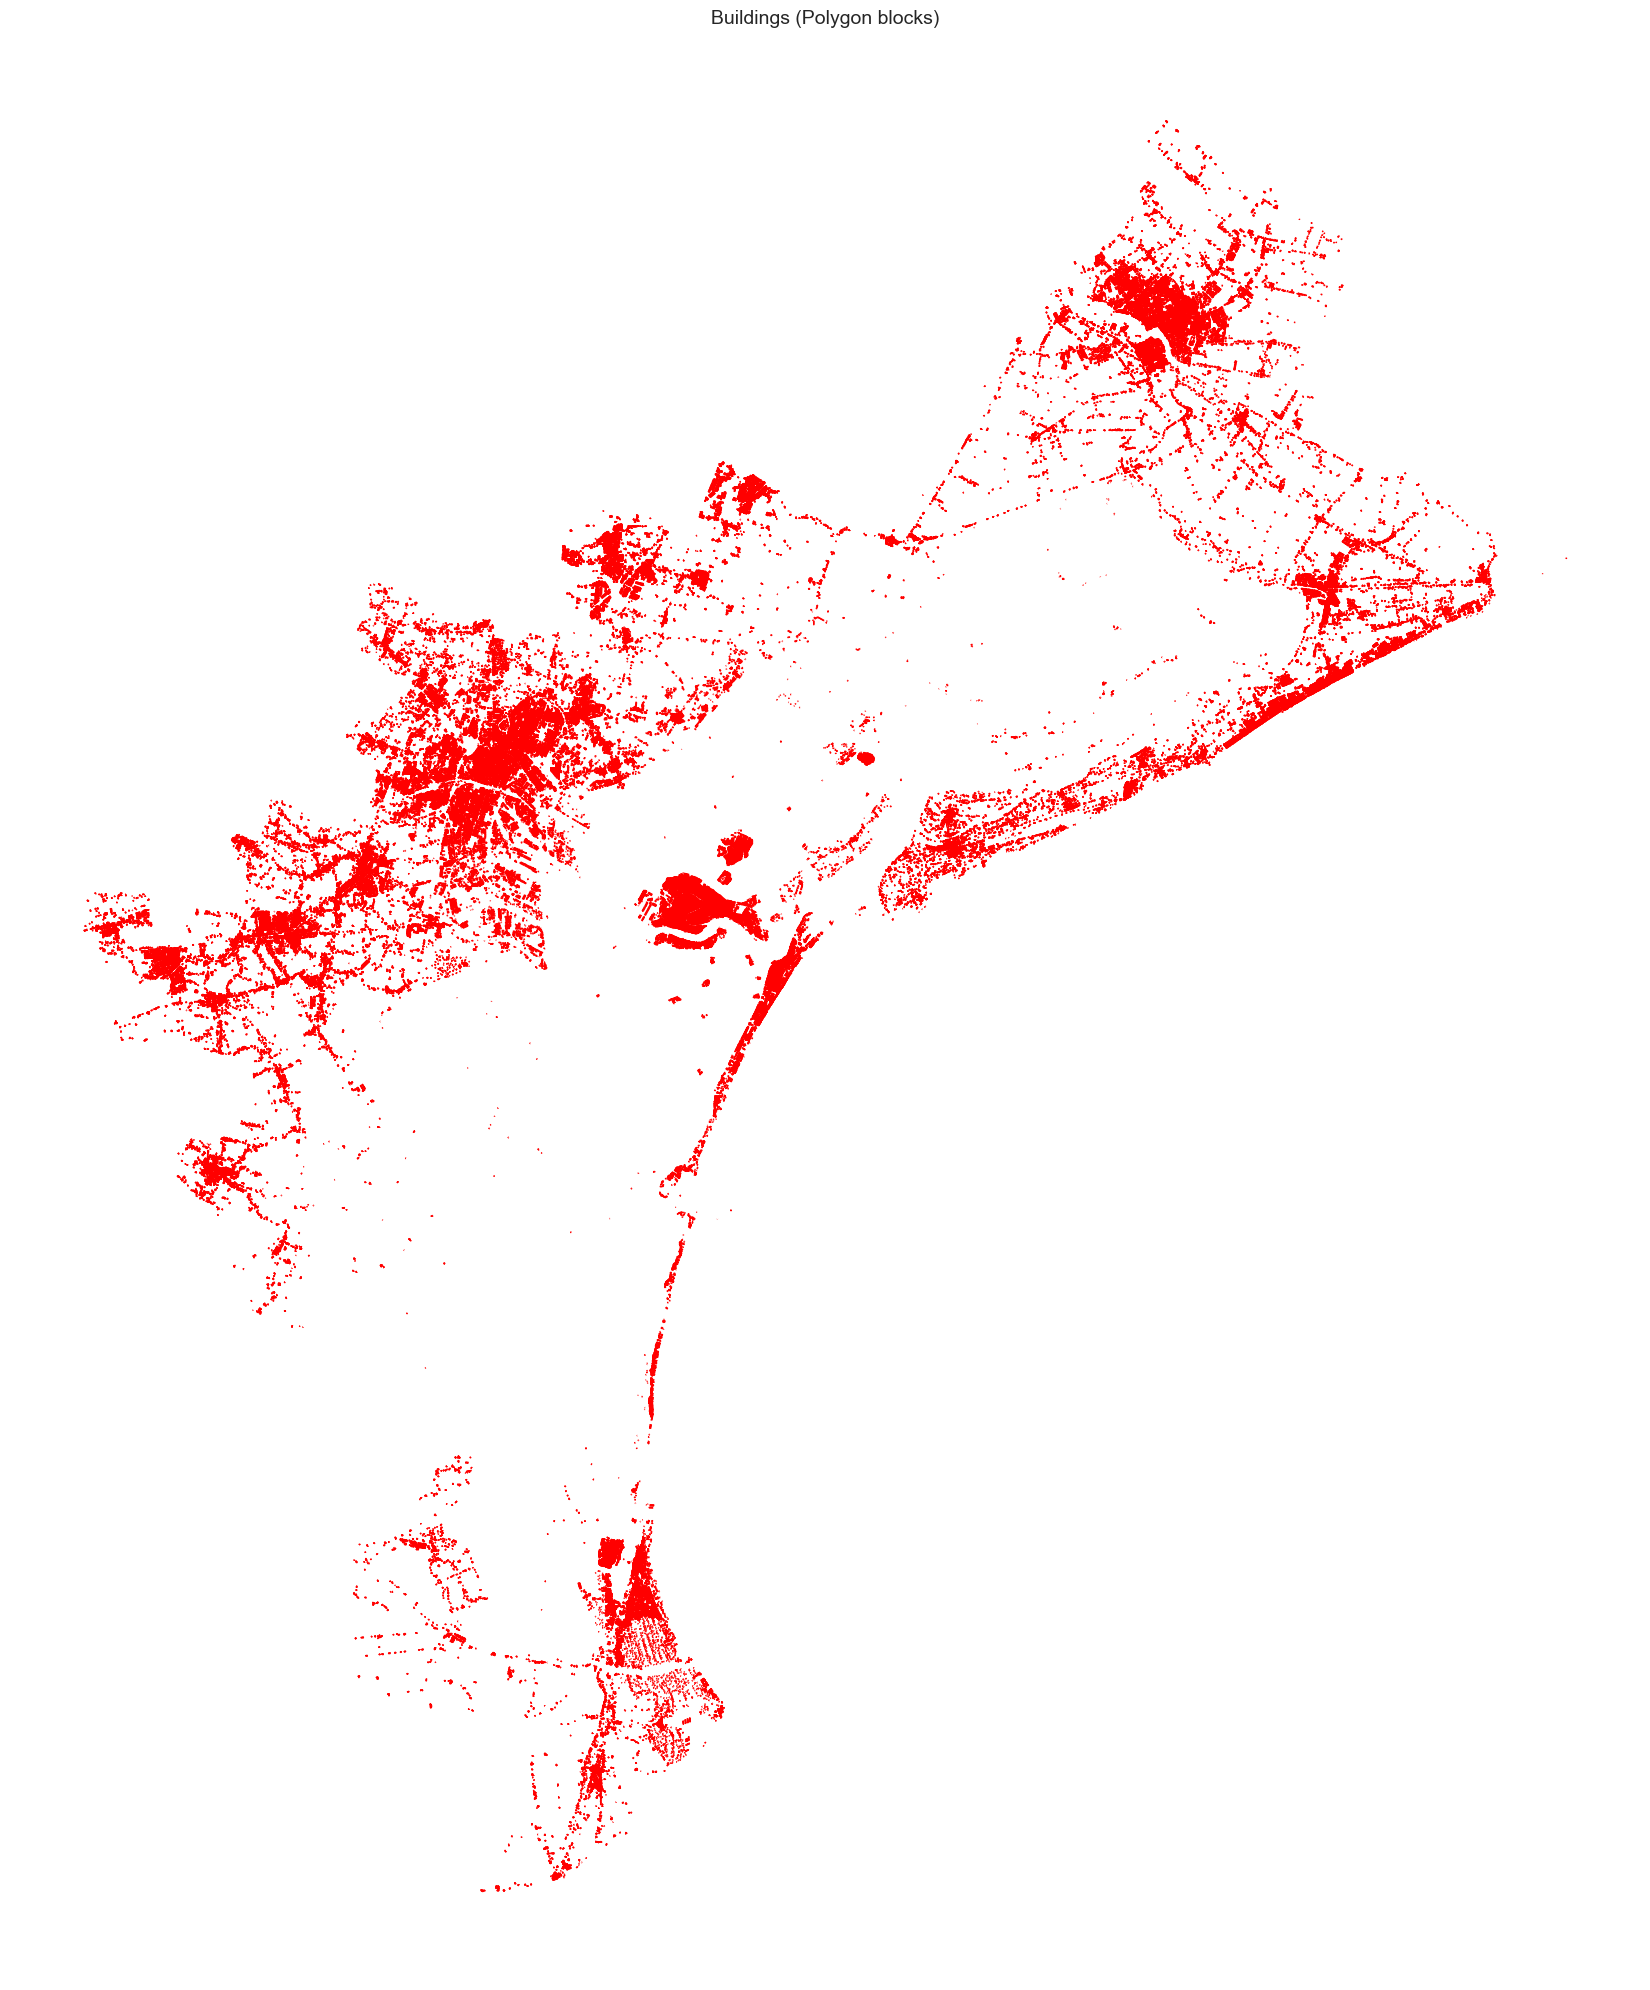

In [3]:
# # 查看数据内容
# print(gdf_industrial)
# gdf_industrial.plot()
fig, ax = plt.subplots(figsize=(20,20))
gdf_buildings.plot(ax=ax, color='red', edgecolor='red')

# 关闭坐标轴并设置标题
ax.set_title("Buildings (Polygon blocks)", fontsize=14)
ax.axis('off')
plt.tight_layout()
plt.show()

# 数据预处理

In [4]:
#building 处理
cultural_types = ['architettura funeraria', 'architettura religiosa', 'torre, porta, arco']
gdf_cultural = gdf_buildings[gdf_buildings['descrizion'].isin(cultural_types)]
#landuse 处理
gdf_landuse["lc_iii_lvl"] = gdf_landuse["lc_iii_lvl"].astype(int).astype(str)
gdf_landuse["lc_iii_lvl"] = gdf_landuse["lc_iii_lvl"].apply(lambda x: f"{x[0]}.{x[1]}.{x[2]}" if len(x) == 3 else x)
gdf_agriculture = gdf_landuse[gdf_landuse["lc_iii_lvl"].str.startswith("2.")]
gdf_industrial = gdf_landuse[gdf_landuse["lc_iii_lvl"].str.startswith("1.2.")]
gdf_water = gdf_landuse[gdf_landuse["lc_iii_lvl"].str.startswith("5.")]
#population 处理


## 创建网格

In [5]:
# 设置格网大小（单位和你的坐标系一致，比如米）
grid_size = 1000  # 每个正方形边长1000米（1公里）

# 获取工厂数据的包络范围 (bounding box)
minx, miny, maxx, maxy = gdf_boundary.total_bounds

# 创建格网
grid_cells = []
x_left = minx
while x_left < maxx:
    y_bottom = miny
    while y_bottom < maxy:
        cell = box(x_left, y_bottom, x_left + grid_size, y_bottom + grid_size)
        grid_cells.append(cell)
        y_bottom += grid_size
    x_left += grid_size

# 转成GeoDataFrame
grid = gpd.GeoDataFrame({'geometry': grid_cells}, crs=gdf_processing.crs)

## 空间连接

In [6]:
# 对于点的处理
# 每个格子ID对应工厂数
join = gpd.sjoin(gdf_processing, grid, how='left', predicate='within')
grid['factory_count'] = join.groupby('index_right').size()
grid['factory_count'] = grid['factory_count'].fillna(0)
# 每个格子ID对应公共服务
join = gpd.sjoin(gdf_services, grid, how='left', predicate='within')
grid['public_services'] = join.groupby('index_right').size()
grid['public_services'] = grid['public_services'].fillna(0)
# 每个格子ID对应废物处理
join = gpd.sjoin(gdf_waste, grid, how='left', predicate='within')
grid['waste_treatment'] = join.groupby('index_right').size()
grid['waste_treatment'] = grid['waste_treatment'].fillna(0)



# 对于线的处理
join = gpd.sjoin(gdf_roads, grid, predicate='intersects')
join['length'] = join.geometry.length
grid['road_length'] = join.groupby('index_right')['length'].sum()
grid['road_length'] = grid['road_length'].fillna(0)



# 对于面的处理
# 每个格子ID对应industrial_area的面积
join = gpd.sjoin(gdf_industrial, grid, predicate='intersects')
join['intersect_area'] = join.geometry.intersection(join['geometry']).area
industrial_area_by_grid = join.groupby('index_right')['intersect_area'].sum()
grid['industrial_area'] = grid.index.map(industrial_area_by_grid).fillna(0)
# 每个格子ID对应industrial_area的面积
join = gpd.sjoin(gdf_agriculture, grid, predicate='intersects')
print(join)
join['intersect_area'] = join.geometry.intersection(join['geometry']).area
agriculture_area_by_grid = join.groupby('index_right')['intersect_area'].sum()
grid['agriculture_area'] = grid.index.map(agriculture_area_by_grid).fillna(0)
# 每个格子ID对应water的面积
join = gpd.sjoin(gdf_water, grid, predicate='intersects')
join['intersect_area'] = join.geometry.intersection(join['geometry']).area
water_area_by_grid = join.groupby('index_right')['intersect_area'].sum()
grid['water_area'] = grid.index.map(water_area_by_grid).fillna(0)


print(grid)

#
# fig, ax = plt.subplots(figsize=(12, 12))
# grid.plot(column='factory_count', cmap='Blues', edgecolor='grey', linewidth=0.5, ax=ax, legend=True)
# # gdf_buildings.plot(ax=ax, color='red', markersize=5)
# plt.title("Factory Counts per Grid Cell", fontsize=15)
# plt.show()

       codice_num    data  lc_i_lvl  lc_ii_lvl lc_iii_lvl  \
335       21100.0  2020.0       2.0       21.0      2.1.1   
335       21100.0  2020.0       2.0       21.0      2.1.1   
336       21100.0  2020.0       2.0       21.0      2.1.1   
337       21100.0  2020.0       2.0       21.0      2.1.1   
338       21100.0  2020.0       2.0       21.0      2.1.1   
...           ...     ...       ...        ...        ...   
17527     24200.0  2020.0       2.0       24.0      2.4.2   
17625     23100.0  2020.0       2.0       23.0      2.3.1   
17626     23100.0  2020.0       2.0       23.0      2.3.1   
17627     23100.0  2020.0       2.0       23.0      2.3.1   
17628     24200.0  2020.0       2.0       24.0      2.4.2   

                                                 legenda codice  \
335                  Terreni arabili in aree non irrigue  2.1.1   
335                  Terreni arabili in aree non irrigue  2.1.1   
336                  Terreni arabili in aree non irrigue  2.1.1   

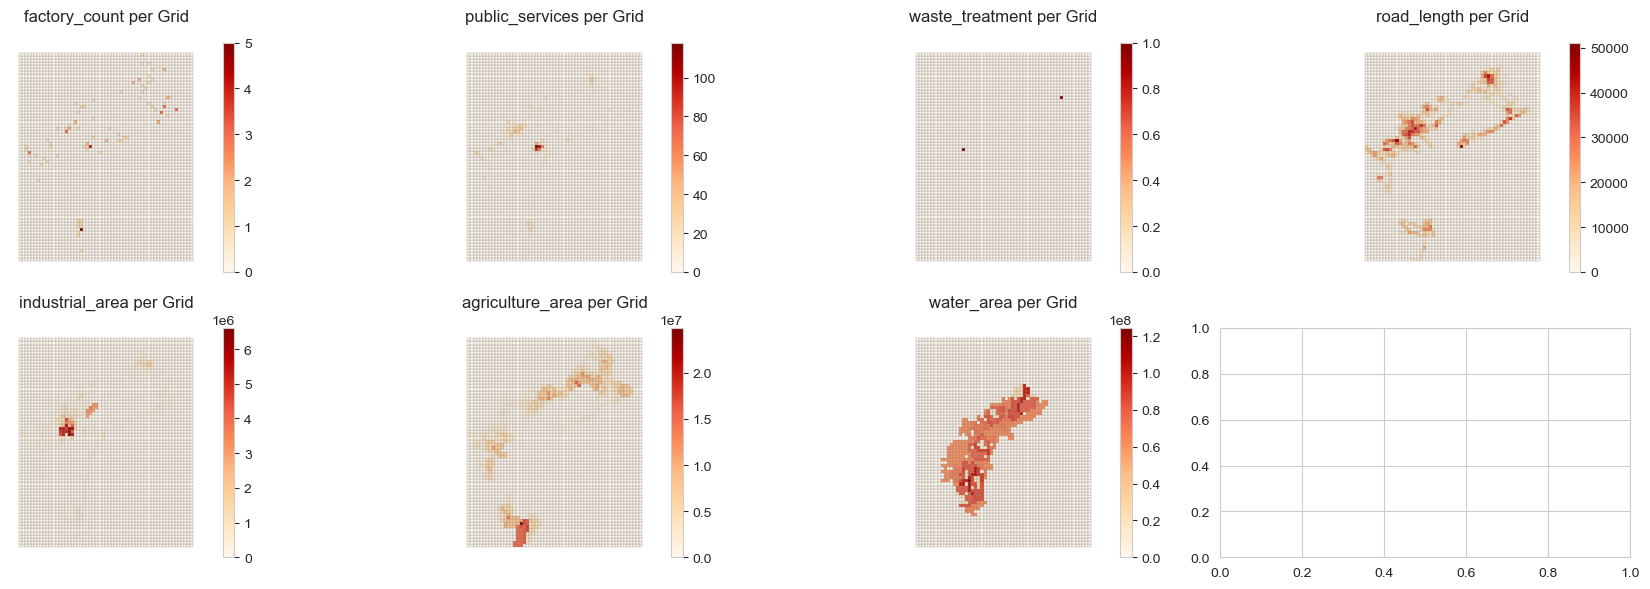

In [7]:
variables = ['factory_count', 'public_services','waste_treatment','road_length', 'industrial_area','agriculture_area','water_area']

fig, axs = plt.subplots(2, 4, figsize=(18, 6))
axs = axs.flatten()
for i, var in enumerate(variables):
    grid.plot(column=var, ax=axs[i], cmap='OrRd', legend=True, edgecolor='grey', linewidth=0.2)
    axs[i].set_title(f'{var} per Grid', fontsize=12)
    axs[i].axis('off')

plt.tight_layout()
plt.show()

      factory_count  public_services  waste_treatment  road_length  \
0               0.0              0.0              0.0          0.0   
1               0.0              0.0              0.0          0.0   
2               0.0              0.0              0.0          0.0   
3               0.0              0.0              0.0          0.0   
4               0.0              0.0              0.0          0.0   
...             ...              ...              ...          ...   
3871            0.0              0.0              0.0          0.0   
3872            0.0              0.0              0.0          0.0   
3873            0.0              0.0              0.0          0.0   
3874            0.0              0.0              0.0          0.0   
3875            0.0              0.0              0.0          0.0   

      industrial_area  agriculture_area  water_area  
0                 0.0               0.0         0.0  
1                 0.0               0.0         0.0

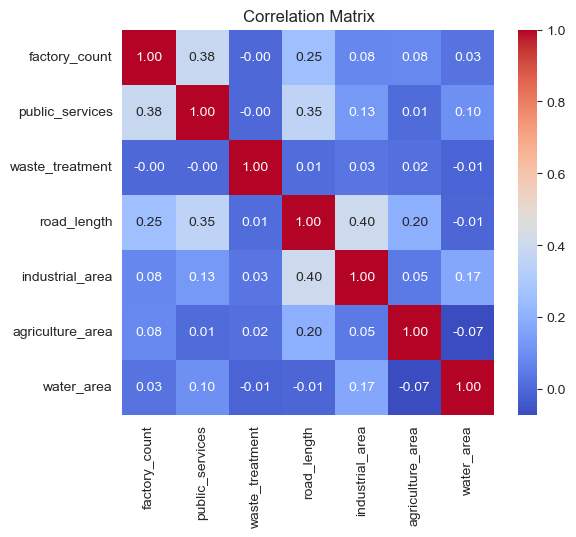

In [11]:
import seaborn as sns
import pandas as pd

# 只提取需要分析的字段
df_analysis = grid[['factory_count', 'public_services','waste_treatment','road_length', 'industrial_area','agriculture_area','water_area']]
print(df_analysis)
# 计算相关性矩阵
corr_matrix = df_analysis.corr()
corr_matrix.to_csv("correlation_matrix.csv")
# 热力图可视化
plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

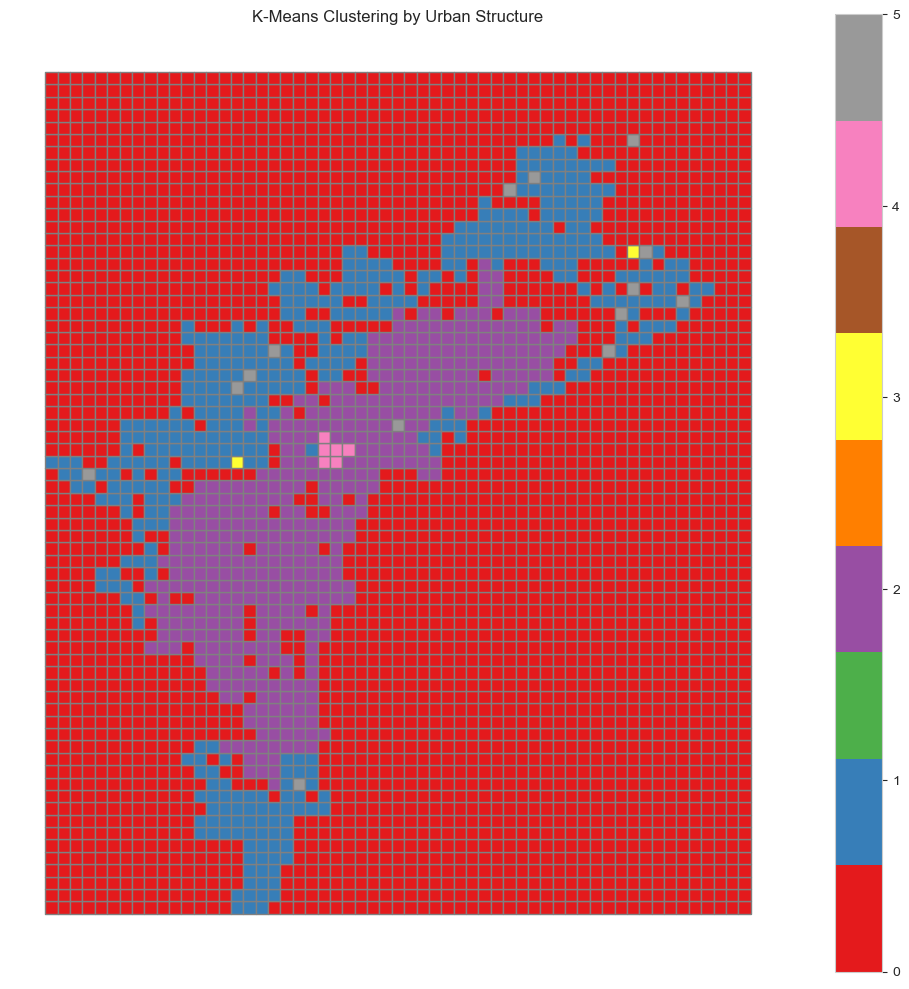

         factory_count  public_services  waste_treatment  road_length  \
cluster                                                                 
0            -0.112367        -0.130922        -0.022721    -0.269052   
1             0.364884         0.549703        -0.022721     2.032087   
2            -0.040048         0.034123        -0.022721    -0.191996   
3            -0.123223        -0.136740        44.011362     0.474922   
4             6.059467        19.465864        -0.022721    -0.214700   
5            11.800535         2.138562        -0.022721     2.930218   

         industrial_area  agriculture_area  water_area  
cluster                                                 
0              -0.159423         -0.221635   -0.373076  
1               1.109168          1.780645   -0.143430  
2              -0.006982         -0.197399    2.613049  
3               1.389744          0.913360   -0.382009  
4               0.426543         -0.336136    2.216965  
5               

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_analysis)
kmeans = KMeans(n_clusters=6, random_state=0)
labels = kmeans.fit_predict(X_scaled)
grid['cluster'] = labels

fig, ax = plt.subplots(figsize=(10, 10))
grid.plot(column='cluster', cmap='Set1', legend=True, ax=ax, edgecolor='grey')
ax.set_title("K-Means Clustering by Urban Structure")
ax.axis('off')
plt.tight_layout()
plt.show()

cluster_means = pd.DataFrame(X_scaled, columns=df_analysis.columns)
cluster_means['cluster'] = labels
result = cluster_means.groupby('cluster').mean()
print(result)

# 建筑体块

In [9]:
from scipy.spatial import cKDTree
# gdf_processing + gdf_buildings
joined = gpd.sjoin( gdf_processing , gdf_buildings, how='left', predicate='within')
print(joined['index_right'].notnull().sum(), "matched to buildings")
print(joined['index_right'].isnull().sum(), "not matched")

# 获取建筑的质心（用于快速索引）
building_centroids = gdf_buildings.geometry.centroid
building_coords = np.array([(p.x, p.y) for p in building_centroids])
tree = cKDTree(building_coords)
# 对每个加工厂找到最近的建筑索引
factory_coords = np.array([(p.x, p.y) for p in gdf_processing.geometry])
dists, idxs = tree.query(factory_coords, k=1)

# 提取匹配的建筑属性
nearest_geometries = gdf_buildings.geometry.iloc[idxs].reset_index(drop=True)

# 合并建筑属性到加工厂 GeoDataFrame
gdf_processing['building_geom'] = nearest_geometries
gdf_processing = gdf_processing[['DENOMINAZI', 'Type', 'geometry', 'building_geom']]
gdf_processing_building = gdf_processing[['DENOMINAZI', 'Type', 'building_geom']]

# # 绘图
# fig, ax = plt.subplots(figsize=(30,30))
#
# # 建筑面（Polygon）
# gdf_buildings.plot(ax=ax, color='grey')
#
# # 加工厂点（Point）
# gdf_processing.plot(ax=ax, color='red', markersize=20, alpha=0.8)
#
# # 额外可视设置
# ax.set_title("Food Processing Sites and Buildings", fontsize=15)
# ax.axis('off')
#
# plt.tight_layout()
# plt.show()

41 matched to buildings
75 not matched


In [10]:
gdf_processing.to_csv("origin_data/processing.csv", index=False)
gdf_processing_building .to_file("origin_data/processing_building.shp")

C:\Users\Elena\AppData\Local\Temp\ipykernel_25388\3054348264.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_processing_building .to_file("origin_data/processing_building.shp")
